<a href="https://colab.research.google.com/github/vedaant912/CAD-Sequence_Prediction/blob/main/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=4075e9244ecfe796b3587621d2967b2d1ae5b808f9f5402d1968a5e80b94ff66
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=9360a60c523f3222f03679fb14e86aa60658f0a0de36a99e660c9c9eb7340868
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 28.42 MiB/s, done.
Resolving deltas: 100% (3/3), done.


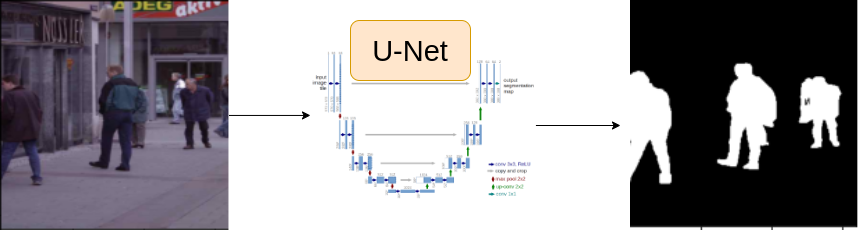

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIRECTORY = '/content'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

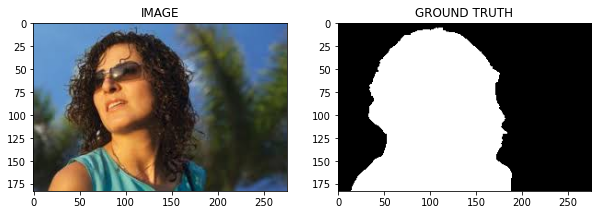

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
# Split the dataset into train and valid set
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
# AUGMENTATION SHOULD BE APPLIED TO IMAGE AS WELL AS LABEL.
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # ( h, w, c )
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2 , 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


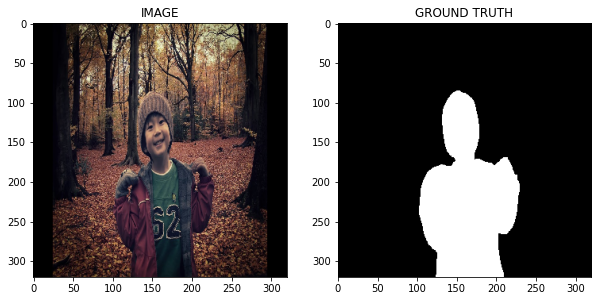

In [ ]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'total no of batches in trainloader : {len(trainloader)}')
print(f'total no of batches in validloader : {len(validloader)}')

total no of batches in trainloader : 15
total no of batches in validloader : 4


In [ ]:
for img, mask in trainloader:
  break

print(f"One batch image shape : {(img.shape)}")
print(f"One batch mask shape : {(mask.shape)}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.6915936628977458 Valid_loss : 0.9267166405916214


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.3625722825527191 Valid_loss : 0.5317748636007309


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


SAVED-MODEL
Epoch : 3 Train_loss : 0.306289404630661 Valid_loss : 0.29657505452632904


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.26003715495268503 Valid_loss : 0.24134507402777672


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


SAVED-MODEL
Epoch : 5 Train_loss : 0.24028531710306802 Valid_loss : 0.23054588958621025


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch : 6 Train_loss : 0.2724019279082616 Valid_loss : 0.2398938685655594


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 7 Train_loss : 0.22317461272080738 Valid_loss : 0.29224859550595284


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 8 Train_loss : 0.1772385999560356 Valid_loss : 0.3062650188803673


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


SAVED-MODEL
Epoch : 9 Train_loss : 0.17152602424224217 Valid_loss : 0.21012190729379654


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch : 10 Train_loss : 0.19794720311959585 Valid_loss : 0.2180563360452652


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


SAVED-MODEL
Epoch : 11 Train_loss : 0.15446509122848512 Valid_loss : 0.20692531764507294


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 12 Train_loss : 0.20270565996567408 Valid_loss : 0.24740653485059738


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch : 13 Train_loss : 0.2107475221157074 Valid_loss : 0.2284935712814331


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


SAVED-MODEL
Epoch : 14 Train_loss : 0.16659626265366873 Valid_loss : 0.18682975694537163


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Epoch : 15 Train_loss : 0.15758602271477382 Valid_loss : 0.20414436981081963


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch : 16 Train_loss : 0.13848620802164077 Valid_loss : 0.1991475149989128


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


SAVED-MODEL
Epoch : 17 Train_loss : 0.12099736134211223 Valid_loss : 0.1854468211531639


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch : 18 Train_loss : 0.11430069903532664 Valid_loss : 0.19043827056884766


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch : 19 Train_loss : 0.11664326588312784 Valid_loss : 0.20808324217796326


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 20 Train_loss : 0.10480767587820689 Valid_loss : 0.23210329562425613


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch : 21 Train_loss : 0.12839742004871368 Valid_loss : 0.18959688767790794


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch : 22 Train_loss : 0.10951461096604666 Valid_loss : 0.19575825333595276


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 23 Train_loss : 0.09182097812493642 Valid_loss : 0.2263622172176838


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


SAVED-MODEL
Epoch : 24 Train_loss : 0.09943695664405823 Valid_loss : 0.17493894509971142


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

Epoch : 25 Train_loss : 0.08602068324883778 Valid_loss : 0.257653646171093


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

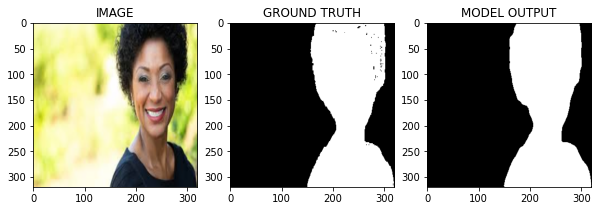

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya